In [0]:
%config InlineBackend.figure_format = 'retina'

from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from scipy.stats import norm, multivariate_normal
from scipy.stats import pearsonr
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

---
# Gaussian Mixture Model Clustering
---

**Oleh :**
    
    - Taufik Fathurahman [1301160790]
    - Brenda Irena [1301164641]
    - Husnul Khotimah Farid [1301162742]

## 1 - Gaussian Mixture Model

K-means clustering model merupakan model yang sangat sederhana dan relatif mudah untuk dipahami, namun dengan kesederhanaan dan kemudahannya itu memiliki kekurangan ketika diterapkan terhadap situasi dunia nyata karena sifat dari k-means yang non-probabilistik. Dari kekurangan yang muncul di k-means dapat diatasi dengan menggunakan metode gaussian mixture models (GMM).

Jika kita mengenal K-means clustering yang memiliki *hard boundaries*, yang artinya suatu data point termasuk kepada cluster tersebut atau bukan. Namun pada GMM, memiliki *soft boundaries*, yang artinya suatu data point dapat dimiliki oleh beberapa cluster secara bersamaan pada waktu yang sama namun memiliki derajat kepercayaan yang berbeda atau probabilitas yang berbeda, sebagai contoh suatu data point memiliki 70% kepercayaan terhadap cluster 1, dan 30% kepercayaan terhadap cluster 2.

## 2 - Gaussian Distribution

Dalam GMM, setiap cluster akan bergantung pada *probability distribution*, yaitu *gaussian distribution*. Persamaan matematika untuk *gaussian distribution 1-dimension (univariate gaussian)*, atau juga disebut sebagai *probability density function (pdf)* adalah sebagai berikut ini:

\begin{equation*}
N(x \mid \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\dfrac{(x-\mu)^2}{2\sigma^2}}
\end{equation*}

**Keterangan :**
* $x$ merupakan random observation dari distribusi
* $\mu$ (mu) atau mean merupakan kontrol dari gaussian untuk "*center position*"
* $\sigma^2$ (sigma) atau variance merupakan kontrol untuk "*shape*" dari cluster.

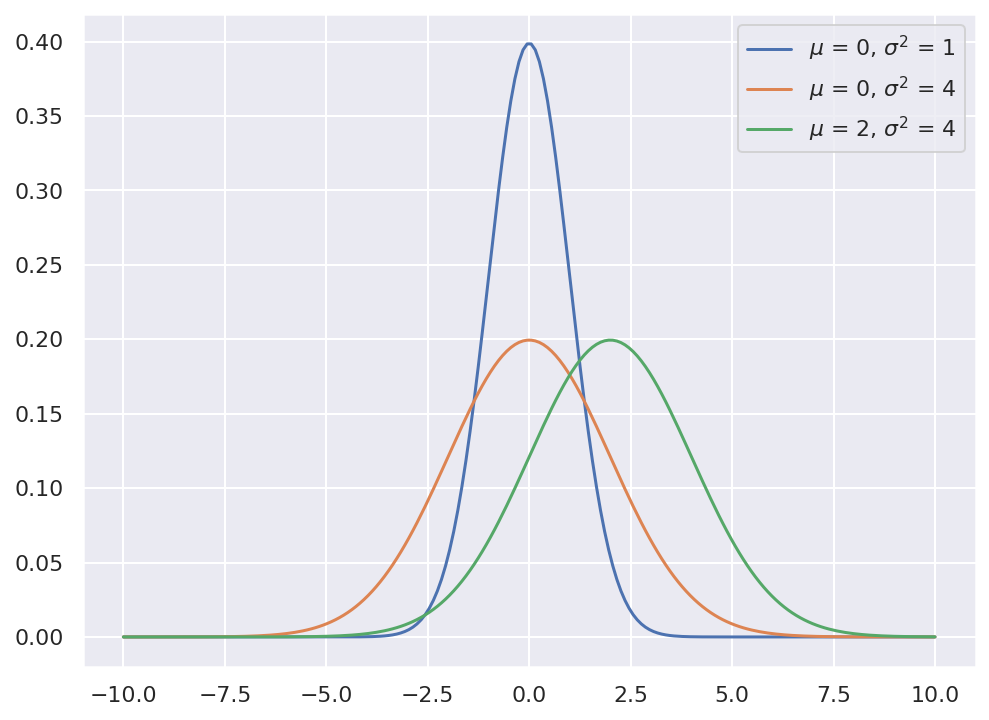

In [0]:
# Gaussian distribution examples

plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

x = np.linspace(start = -10, stop = 10, num = 200)
mean = [0, 0, 2]
var = [1, 4, 4]

for m, v in zip(mean, var):
    y = norm(m, np.sqrt(v)).pdf(x)
    plt.plot(x, y, label = '$\mu$ = {}, $\sigma^2$ = {}'.format(m, v))
    plt.legend()

plt.show()

Jika pada contoh diatas merupakan 1 dimensi, lalu untuk dimensi yang lebih dari 1 atau *multivariate* adalah sebagai berikut ini:

$$N(x \mid \mu,\Sigma) = \frac{1}{(2\pi)^{d/2}\sqrt{|\Sigma|}}exp(-\dfrac{1}{2}(x-\mu)^{T}\Sigma^{-1}(x-\mu))$$

**Keterangan :**
* $\mu$ (mu) merupakan vector
* $\Sigma$ merupakan d-by-d covariance covariance matrix
* $|\Sigma|$ determinant dari covariance matrix

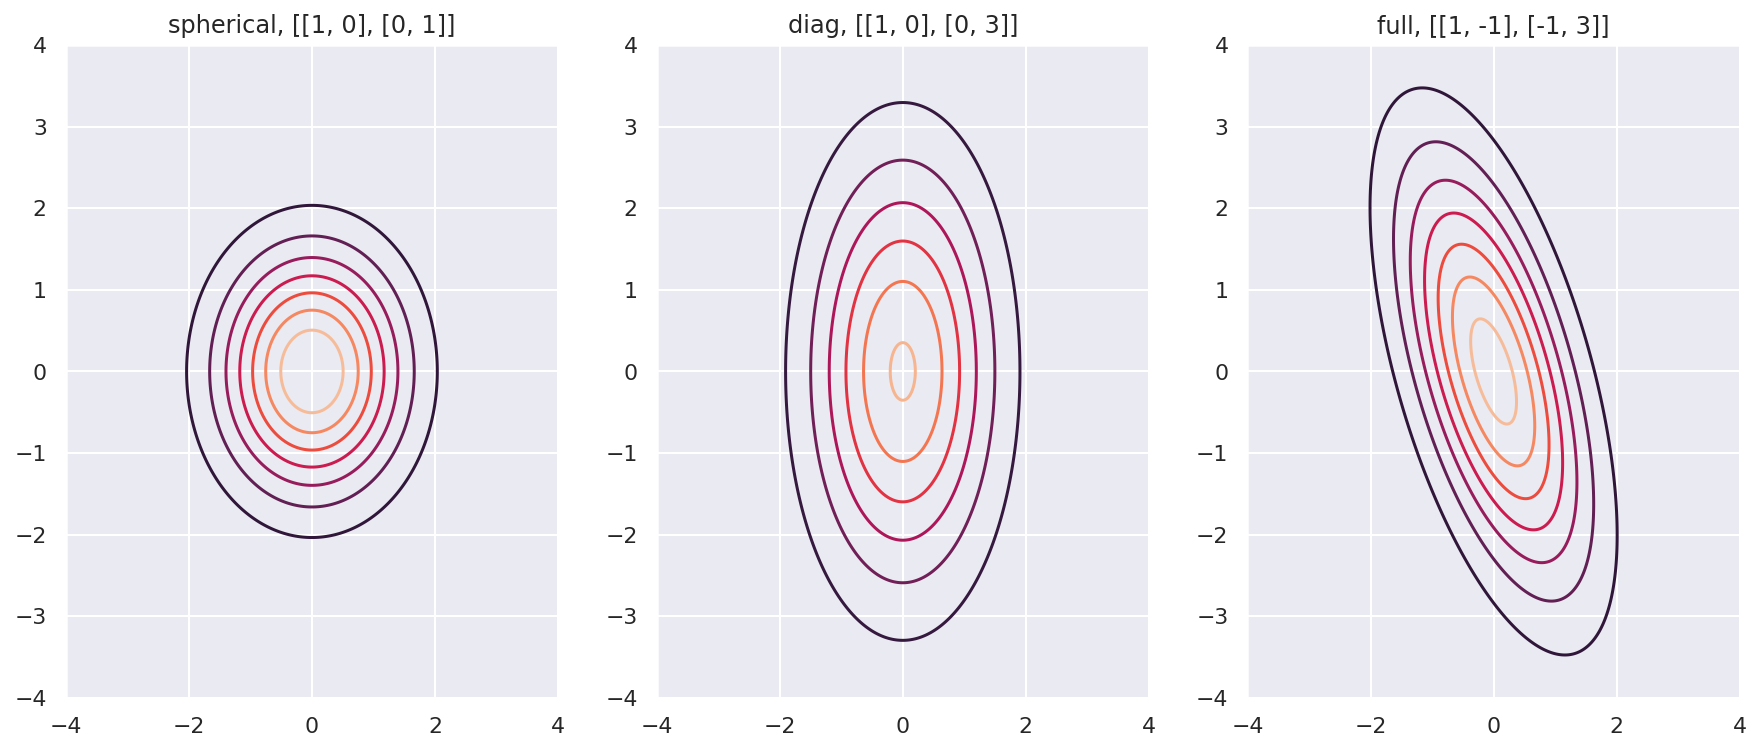

In [0]:
# Covariance type examples

x, y = np.mgrid[-4:4:.01, -4:4:.01]
position = np.empty(x.shape + (2,))
position[:, :, 0] = x
position[:, :, 1] = y

covariances = [ [[1, 0], [0, 1]], [[1, 0], [0, 3]], [[1, -1], [-1, 3]] ]
titles = ['spherical', 'diag', 'full']

plt.figure(figsize = (15, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    z = multivariate_normal([0, 0], covariances[i]).pdf(position)
    plt.contour(x, y, z)
    plt.title('{}, {}'.format(titles[i], covariances[i]))
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plt.show()

## 2 - Estimasi Parameter

Akan digunakan ilustrasi dengan menggunakan 1-dimension data untuk melakukan estimasi mean dan variance-nya. Contoh dua data points yang akan digunakan adalah sebagai berikut:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


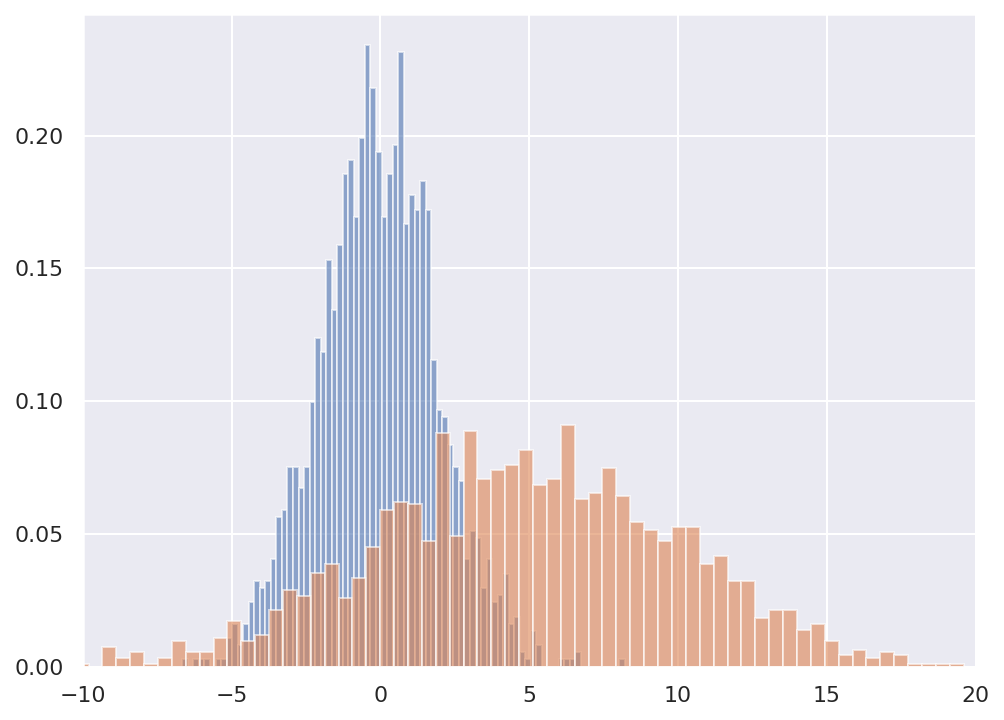

In [0]:
np.random.seed(2)
x1 = np.random.normal(0, 2, size = 2000)
x2 = np.random.normal(5, 5, size = 2000)
data = [x1, x2]
def plot_hist(data):
    for x in data:
        plt.hist(x, bins = 80, normed = True, alpha = 0.6)
        
    plt.xlim(-10, 20)

plot_hist(data)

Langkah selanjutnya adalah melakukan komputasi terhadap mean dan variance untuk kedua datapoint yang sudah dibuat diatas. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


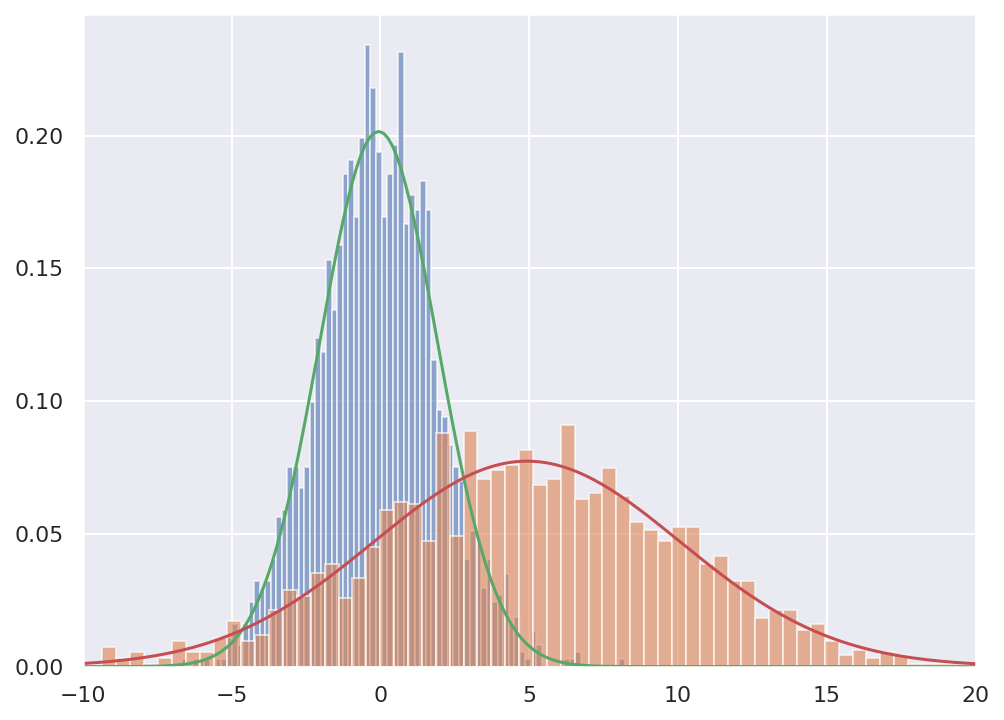

In [0]:
x1_mean, x1_var = np.mean(x1), np.var(x1)
x2_mean, x2_var = np.mean(x2), np.var(x2)
x_mean = [x1_mean, x2_mean]
x_var = [x1_var, x2_var]

def plot_guassian(x_mean, x_var):
    x = np.linspace(start = -10, stop = 20, num = 200)
    for m, v in zip(x_mean, x_var):
        y = norm(m, np.sqrt(v)).pdf(x)
        plt.plot(x, y)

plot_hist(data)
plot_guassian(x_mean, x_var)

Lalu bagaimana bila kita dihadapkan dengan situasi dimana memilki sangat banyak data points yang berasal dari K gaussian berbeda?

Situasi ini dapat diselesai dengan menggunakan EM algorithm.


### 2.1 - E-step

Dengan menggunakan means dan variances yang dimiliki, dapat digunakan untuk mencari tau probabilitas dari setiap data points $x_{i}$ yang berasal dari setiap gaussian.

Untuk memulainya, mari mulai dengan inisialisasi nilai dari parameter $\pi_k, \mu_k$ dan $\Sigma_k$ secara random dan formula yang dibutuhkan untuk melakukan komputasi *soft assigments* adalah sebagai berikut:

$$r_{ik} = \frac{ \pi_k N(x_i \mid \mu_k,\Sigma_k) }{ \sum_{j=1}^K \pi_j N(x_i \mid \mu_j,\Sigma_j) }$$

**Keterangan :**

* $r_{ik}$ meruapan responsibility vector
* $K$ meruapakn banyaknya cluster
* $N(x_i \mid \mu_k,\Sigma_k)$ merupakan likelihood dari datapoints $x_i$ yang berasal dari setiap cluster $k$.

Langkah selanjutnya adalah melakukan komputasi responsibility, yaitu normalisasi terhadap semua cluster sehingga menghasilkan valid probabilitas.

### 2.2 - M-Step

Setelah melakukan perhitungan responsibility vector, pada M-Step akan dilakukan proses memperbarui parameter dari GMM, yang diantaranya adalah:

$$\begin{align*}
N_k^{soft} &= \sum_{i=1}^N r_{ik} \\ \nonumber
\pi_k &= \frac{N_k^{soft}}{N_k} \\ \nonumber
\hat{\mu}_k &= \frac{1}{N_k^{soft}} \sum_{i=1}^N r_{ik} x_i \\ \nonumber
\hat{\Sigma}_k &= \frac{1}{N_k^{soft}} \sum_{i=1}^N r_{ik} (x_i-\hat{\mu}_k)(x_i - \hat{\mu}_k)^T \nonumber
\end{align*}$$

**Keterangan :**

* $N^{\text{soft}}_{k}$ merupakan soft count dari semua data points $N$
* $\pi_k$ merupakan weight dari cluster

## 3 - Menentukan Jumlah Gaussian Paling Optimum

GMM memiliki kesamaan dengan K-Means yaitu membutuhkan jumlah cluster yang spesifik sebelum melakukan proses *training*. Dalam mengatasi ini, ada dua metode yang dapat digunakan dalam menentukan jumlah cluster paling optimum, yaitu:

1. **Aikaki Information Criterion (AIC)**
    Merupakan penaksir kesalah prediksi dari sampel yang diberikan dengan persamaan sebagai berikut ini:
    $$\mathrm {AIC} =2  \cdot p - 2  \cdot \ln(L)$$
2. **Bayesian Information Criterion (BIC)**
    Merupan penaksir kesalahan prediksi dari sampel yang diberikan dengan persamaan sebagai berikut ini:
    $$\mathrm{BIC} = {-2 \cdot \ln(L) + p \cdot \ln(N)}$$

Dari kedua criterion evalusi, dapatkan nilai paling minimum untuk dijadikan jumlah gaussian.

**Keterangan :**
* $L$ merupakan maximum value dari *likelihood function*
* $p$ merupakan estimasi banyaknya parameter dari model
* $N$ Banyaknya data points

---
# Implementasi GMM
--- 

In [0]:
class BaseEstimator(object):
    '''
    Digunakan untuk memastikan input memenuhi kriteria.
    - Memastikan X disimpan dalam bentuk numpy ndarrays.

    Parameter
    ---------
    X : (array-like) Feature dataset.
    '''
    X = None
    fit_required = True

    def _setup_input(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if X.size == 0:
            raise ValueError("Number of features must be > 0")

        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])

        self.X = X

    def fit(self, X):
        self._setup_input(X)

    def _predict(self, X):
        raise NotImplementedError()

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

In [0]:
def euclidean_distance(a, b):
    if isinstance(a, list) and isinstance(b, list):
        a = np.array(a)
        b = np.array(b)

    return math.sqrt(sum((a - b) ** 2))
    
class KMeans(BaseEstimator):
    """
    Class KMeans akan digunakan sebagai salah satu inisialisasi nilai awal dari 
    algoritma gaussian mixture model
    """

    y_required = False

    def __init__(self, K=5, max_iters=100, init="random"):
        self.K = K
        self.max_iters = max_iters
        self.clusters = [[] for _ in range(self.K)]
        self.centroids = []
        self.init = init

    def _initialize_centroids(self, init):
        """Inisialisasi centroid."""
        if init == "random":
            self.centroids = [self.X[x] for x in random.sample(range(self.n_samples), self.K)]
        elif init == "++":
            self.centroids = [random.choice(self.X)]
            while len(self.centroids) < self.K:
                self.centroids.append(self._choose_next_center())
        else:
            raise ValueError("Unknown type of init parameter")

    def _predict(self, X=None):
        """melakukan clustering pada data."""
        self._initialize_centroids(self.init)
        centroids = self.centroids

        # Optimize clusters
        for _ in range(self.max_iters):
            self._assign(centroids)
            centroids_old = centroids
            centroids = [self._get_centroid(cluster) for cluster in self.clusters]

            if self._is_converged(centroids_old, centroids):
                break

        self.centroids = centroids

        return self._get_predictions()

    def _get_predictions(self):
        predictions = np.empty(self.n_samples)

        for i, cluster in enumerate(self.clusters):
            for index in cluster:
                predictions[index] = i
        return predictions

    def _assign(self, centroids):
        for row in range(self.n_samples):
            for i, cluster in enumerate(self.clusters):
                if row in cluster:
                    self.clusters[i].remove(row)
                    break

            closest = self._closest(row, centroids)
            self.clusters[closest].append(row)

    def _closest(self, fpoint, centroids):
        """Mendapatkan centroid terdekat dari suatu datapoint"""
        closest_index = None
        closest_distance = None
        for i, point in enumerate(centroids):
            dist = euclidean_distance(self.X[fpoint], point)
            if closest_index is None or dist < closest_distance:
                closest_index = i
                closest_distance = dist
        return closest_index

    def _get_centroid(self, cluster):
        """Mendapatkan mean dari centroid."""
        return [np.mean(np.take(self.X[:, i], cluster)) for i in range(self.n_features)]

    def _dist_from_centers(self):
        """Menghitung jarak dari centroid."""
        return np.array([min([euclidean_distance(x, c) for c in self.centroids]) for x in self.X])

    def _choose_next_center(self):
        distances = self._dist_from_centers()
        squared_distances = distances ** 2
        probs = squared_distances / squared_distances.sum()
        ind = np.random.choice(self.X.shape[0], 1, p=probs)[0]
        return self.X[ind]

    def _is_converged(self, centroids_old, centroids):
        """Menghitung jarak centroid lama dengan yang baru."""
        distance = 0
        for i in range(self.K):
            distance += euclidean_distance(centroids_old[i], centroids[i])
        return distance == 0

In [0]:
class GMM(BaseEstimator):
    '''
    Parameters
    ----------

    n_components : (int) banyak cluster 
    max_iters : (int) maximum iterasi yang akan dilakukan dalam melakukan EM-step
    init_params : (str) default 'random'
                    Digunakan dalam melakukan inisialisasi pertamakali pada saat clustering.
                    'random' - secara random memilih nilai dari dataset X untuk dijadikan sebagai centroids.
                    'kmeans' - Melakukan inisialisasi dengan menggunakan kmeans yang sudah dibuat sebelumnya
                                untuk mengisi nilai centroids, covariances, dan weights.
    tol : merupakan tolerasi dari 2 likelihood terbaru sebagai covariance
    '''
    y_required = False

    def __init__(self, n_components=4, tol=1e-3, reg_covar=1e-6, max_iters=500, init_params="random", random_state=0):
        self.n_components = n_components
        self.max_iters = max_iters
        self.init_params = init_params
        self.assignments = None
        self.likelihood = []
        self.tol = tol
        self.random_state = random_state
        self.reg_covar = reg_covar

    def _initialize(self):
        self.weights = np.ones(self.n_components)
        if self.init_params == "random":
            np.random.seed(self.random_state)
            self.means = [self.X[x] for x in random.sample(range(self.n_samples), self.n_components)]
            self.covs = [np.cov(self.X.T) for _ in range(self.n_components)]
        elif self.init_params == "kmeans":
            kmeans = KMeans(self.n_components, max_iters=self.max_iters // 3, init="++")
            kmeans.fit(self.X)
            self.assignments = kmeans.predict(self.X)
            self.means = kmeans.centroids
            self.covs = []
            for i in np.unique(self.assignments):
                self.weights[int(i)] = (self.assignments == i).sum()
                self.covs.append(np.cov(self.X[self.assignments == i].T))
        else:
            raise ValueError("Unknown type of init parameter")
        self.weights /= self.weights.sum()

    def _E_step(self):
        """Expectation(E-step) untuk Gaussian Mixture"""
        likelihoods = self._get_likelihood(self.X)
        self.likelihood.append(likelihoods.sum())
        weighted_likelihoods = self._get_weighted_likelihood(likelihoods)
        self.assignments = weighted_likelihoods.argmax(axis=1)
        weighted_likelihoods /= weighted_likelihoods.sum(axis=1)[:, np.newaxis]
        self.responsibilities = weighted_likelihoods

    def _M_step(self):
        """Maximization (M-step) untuk Gaussian Mixture."""
        weights = self.responsibilities.sum(axis=0)
        for assignment in range(self.n_components):
            resp = self.responsibilities[:, assignment][:, np.newaxis]
            self.means[assignment] = (resp * self.X).sum(axis=0) / resp.sum()
            self.covs[assignment] = ((self.X - self.means[assignment]).T.dot(
                (self.X - self.means[assignment]) * resp
            ) / weights[assignment])
        self.weights = weights / weights.sum()

    def _is_converged(self):
        """Melakukan validasi nilai dari 2 likelihood terbaru terhadap batas tolerasi 'tol'"""
        if (len(self.likelihood) > 1) and (self.likelihood[-1] - self.likelihood[-2] <= self.tol):
            return True
        return False

    def fit(self, X):
        """Melakukan proses Expectation–Maximization (EM) sampai convergen atau batas maksimal iterasi."""
        self._setup_input(X)
        self._initialize()
        for _ in range(self.max_iters):
            self._E_step()
            self._M_step()
            if self._is_converged():
                break

    def _get_likelihood(self, data):
        """mendapatkan likelihood dengan menggukana probability density function"""
        n_data = data.shape[0]
        likelihoods = np.zeros([n_data, self.n_components])
        for c in range(self.n_components):
            distribution = multivariate_normal(
                self.means[c],
                np.fill_diagonal(self.covs[c], self.reg_covar)
            )
            likelihoods[:, c] = distribution.pdf(data)
        return likelihoods

    def _get_weighted_likelihood(self, likelihood):
        return self.weights * likelihood

    def _predict(self, X):
        """Get the assignments for X with GMM clusters."""
        if not X.shape:
            return self.assignments
        likelihoods = self._get_likelihood(X)
        weighted_likelihoods = self._get_weighted_likelihood(likelihoods)
        assignments = weighted_likelihoods.argmax(axis=1)
        return assignments

    @staticmethod
    def get_optimum_cluster(X, max_n):
        """
        Mendapatkan banyaknya gaussian yang paling optimal,
        proses ini hanya dapat dilakukan bila dataset memiliki tepat 2 fitur saja.
        """
        n_components = np.arange(1, max_n)
        clfs = [GaussianMixture(n, max_iter = 1000).fit(X) for n in n_components]
        bics = [clf.bic(X) for clf in clfs]
        aics = [clf.aic(X) for clf in clfs]

        plt.plot(n_components, bics, label = 'BIC')
        plt.plot(n_components, aics, label = 'AIC')
        plt.xlabel('n_components')
        plt.legend()
        plt.show();


    def plot(self, data=None, ax=None, holdon=False):
        """Plot contour for 2D data."""
        if not (len(self.X.shape) == 2 and self.X.shape[1] == 2):
            raise AttributeError("Only support for visualizing 2D data.")

        if ax is None:
            _, ax = plt.subplots()

        if data is None:
            data = self.X
            assignments = self.assignments
        else:
            assignments = self.predict(data)

        COLOR = "bgrcmyk"
        cmap = lambda assignment: COLOR[int(assignment) % len(COLOR)]

        # generate grid
        delta = 0.025
        margin = 0.2
        xmax, ymax = self.X.max(axis=0) + margin
        xmin, ymin = self.X.min(axis=0) - margin
        axis_X, axis_Y = np.meshgrid(np.arange(xmin, xmax, delta), np.arange(ymin, ymax, delta))

        def grid_gaussian_pdf(mean, cov):
            grid_array = np.array(list(zip(axis_X.flatten(), axis_Y.flatten())))
            return multivariate_normal.pdf(grid_array, mean, cov).reshape(axis_X.shape)

        # plot scatters
        if assignments is None:
            c = None
        else:
            c = [cmap(assignment) for assignment in assignments]
        ax.scatter(data[:, 0], data[:, 1], c=c)

        # plot contours
        for assignment in range(self.n_components):
            ax.contour(
                axis_X,
                axis_Y,
                grid_gaussian_pdf(self.means[assignment], self.covs[assignment]),
                colors=cmap(assignment),
            )

        if not holdon:
            plt.title('Plot Cluster')
            plt.show()


## Simple Dataset Exploration

In [0]:
SELECTED_COLS = ['bathrooms', 'waterfront', 'sqft_above', 'sqft_living15', 'grade', 
                 'yr_renovated', 'price', 'bedrooms', 'long', 'sqft_lot15', 'sqft_living', 
                 'condition', 'lat', 'sqft_basement', 'yr_built', 'sqft_lot', 'view']
                 
raw_dataset = pd.read_csv(
    'https://raw.githubusercontent.com/Jonasyao/Machine-Learning-Specialization-University-of-Washington-/master/Regression/Assignment_four/kc_house_data.csv',
    dtype={'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 
           'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 
           'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 
           'floors':str, 'condition':int, 'lat':float, 'date':str, 
           'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int},
    na_values = "NaN",
    usecols = SELECTED_COLS,
    sep=",", 
    skipinitialspace=True 
)

In [0]:
raw_dataset

price  bedrooms  bathrooms  ...     long  sqft_living15  sqft_lot15
0     221900.0       3.0       1.00  ... -122.257         1340.0      5650.0
1     538000.0       3.0       2.25  ... -122.319         1690.0      7639.0
2     180000.0       2.0       1.00  ... -122.233         2720.0      8062.0
3     604000.0       4.0       3.00  ... -122.393         1360.0      5000.0
4     510000.0       3.0       2.00  ... -122.045         1800.0      7503.0
...        ...       ...        ...  ...      ...            ...         ...
3160  485000.0       3.0       2.50  ... -122.378         1970.0      7920.0
3161  780000.0       3.0       1.50  ... -122.381         2440.0      7800.0
3162  720000.0       2.0       1.50  ... -122.388         1880.0      7560.0
3163  415000.0       3.0       1.00  ... -122.119         2040.0     50965.0
3164  480000.0       4.0       1.00  ... -122.300            NaN         NaN

[3165 rows x 17 columns]

### a. Handle Missing Value

In [0]:
total = raw_dataset.isnull().sum().sort_values(ascending=False)
percent = (raw_dataset.isnull().sum()/raw_dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

Total   Percent
sqft_lot15         1  0.000316
sqft_living15      1  0.000316
condition          0  0.000000
bedrooms           0  0.000000
bathrooms          0  0.000000
sqft_living        0  0.000000
sqft_lot           0  0.000000
waterfront         0  0.000000
view               0  0.000000
grade              0  0.000000
sqft_above         0  0.000000
sqft_basement      0  0.000000
yr_built           0  0.000000
yr_renovated       0  0.000000
lat                0  0.000000
long               0  0.000000
price              0  0.000000

In [0]:
'''
Karena missing value hanya berjumlah 2 data saja, maka kami memutuskan untuk menghiraukan 
row dataset yang memiliki missing value
'''
clean_dataset = raw_dataset.drop(raw_dataset.loc[raw_dataset['sqft_lot15'].isnull()].index)
clean_dataset = raw_dataset.drop(raw_dataset.loc[raw_dataset['sqft_living15'].isnull()].index)

In [0]:
# memerika missing value 
clean_dataset.isnull().sum().max()

0

In [0]:
clean_dataset

price  bedrooms  bathrooms  ...     long  sqft_living15  sqft_lot15
0     221900.0       3.0       1.00  ... -122.257         1340.0      5650.0
1     538000.0       3.0       2.25  ... -122.319         1690.0      7639.0
2     180000.0       2.0       1.00  ... -122.233         2720.0      8062.0
3     604000.0       4.0       3.00  ... -122.393         1360.0      5000.0
4     510000.0       3.0       2.00  ... -122.045         1800.0      7503.0
...        ...       ...        ...  ...      ...            ...         ...
3159  431000.0       3.0       1.75  ... -122.360         1600.0     11120.0
3160  485000.0       3.0       2.50  ... -122.378         1970.0      7920.0
3161  780000.0       3.0       1.50  ... -122.381         2440.0      7800.0
3162  720000.0       2.0       1.50  ... -122.388         1880.0      7560.0
3163  415000.0       3.0       1.00  ... -122.119         2040.0     50965.0

[3164 rows x 17 columns]

### b. Correlation

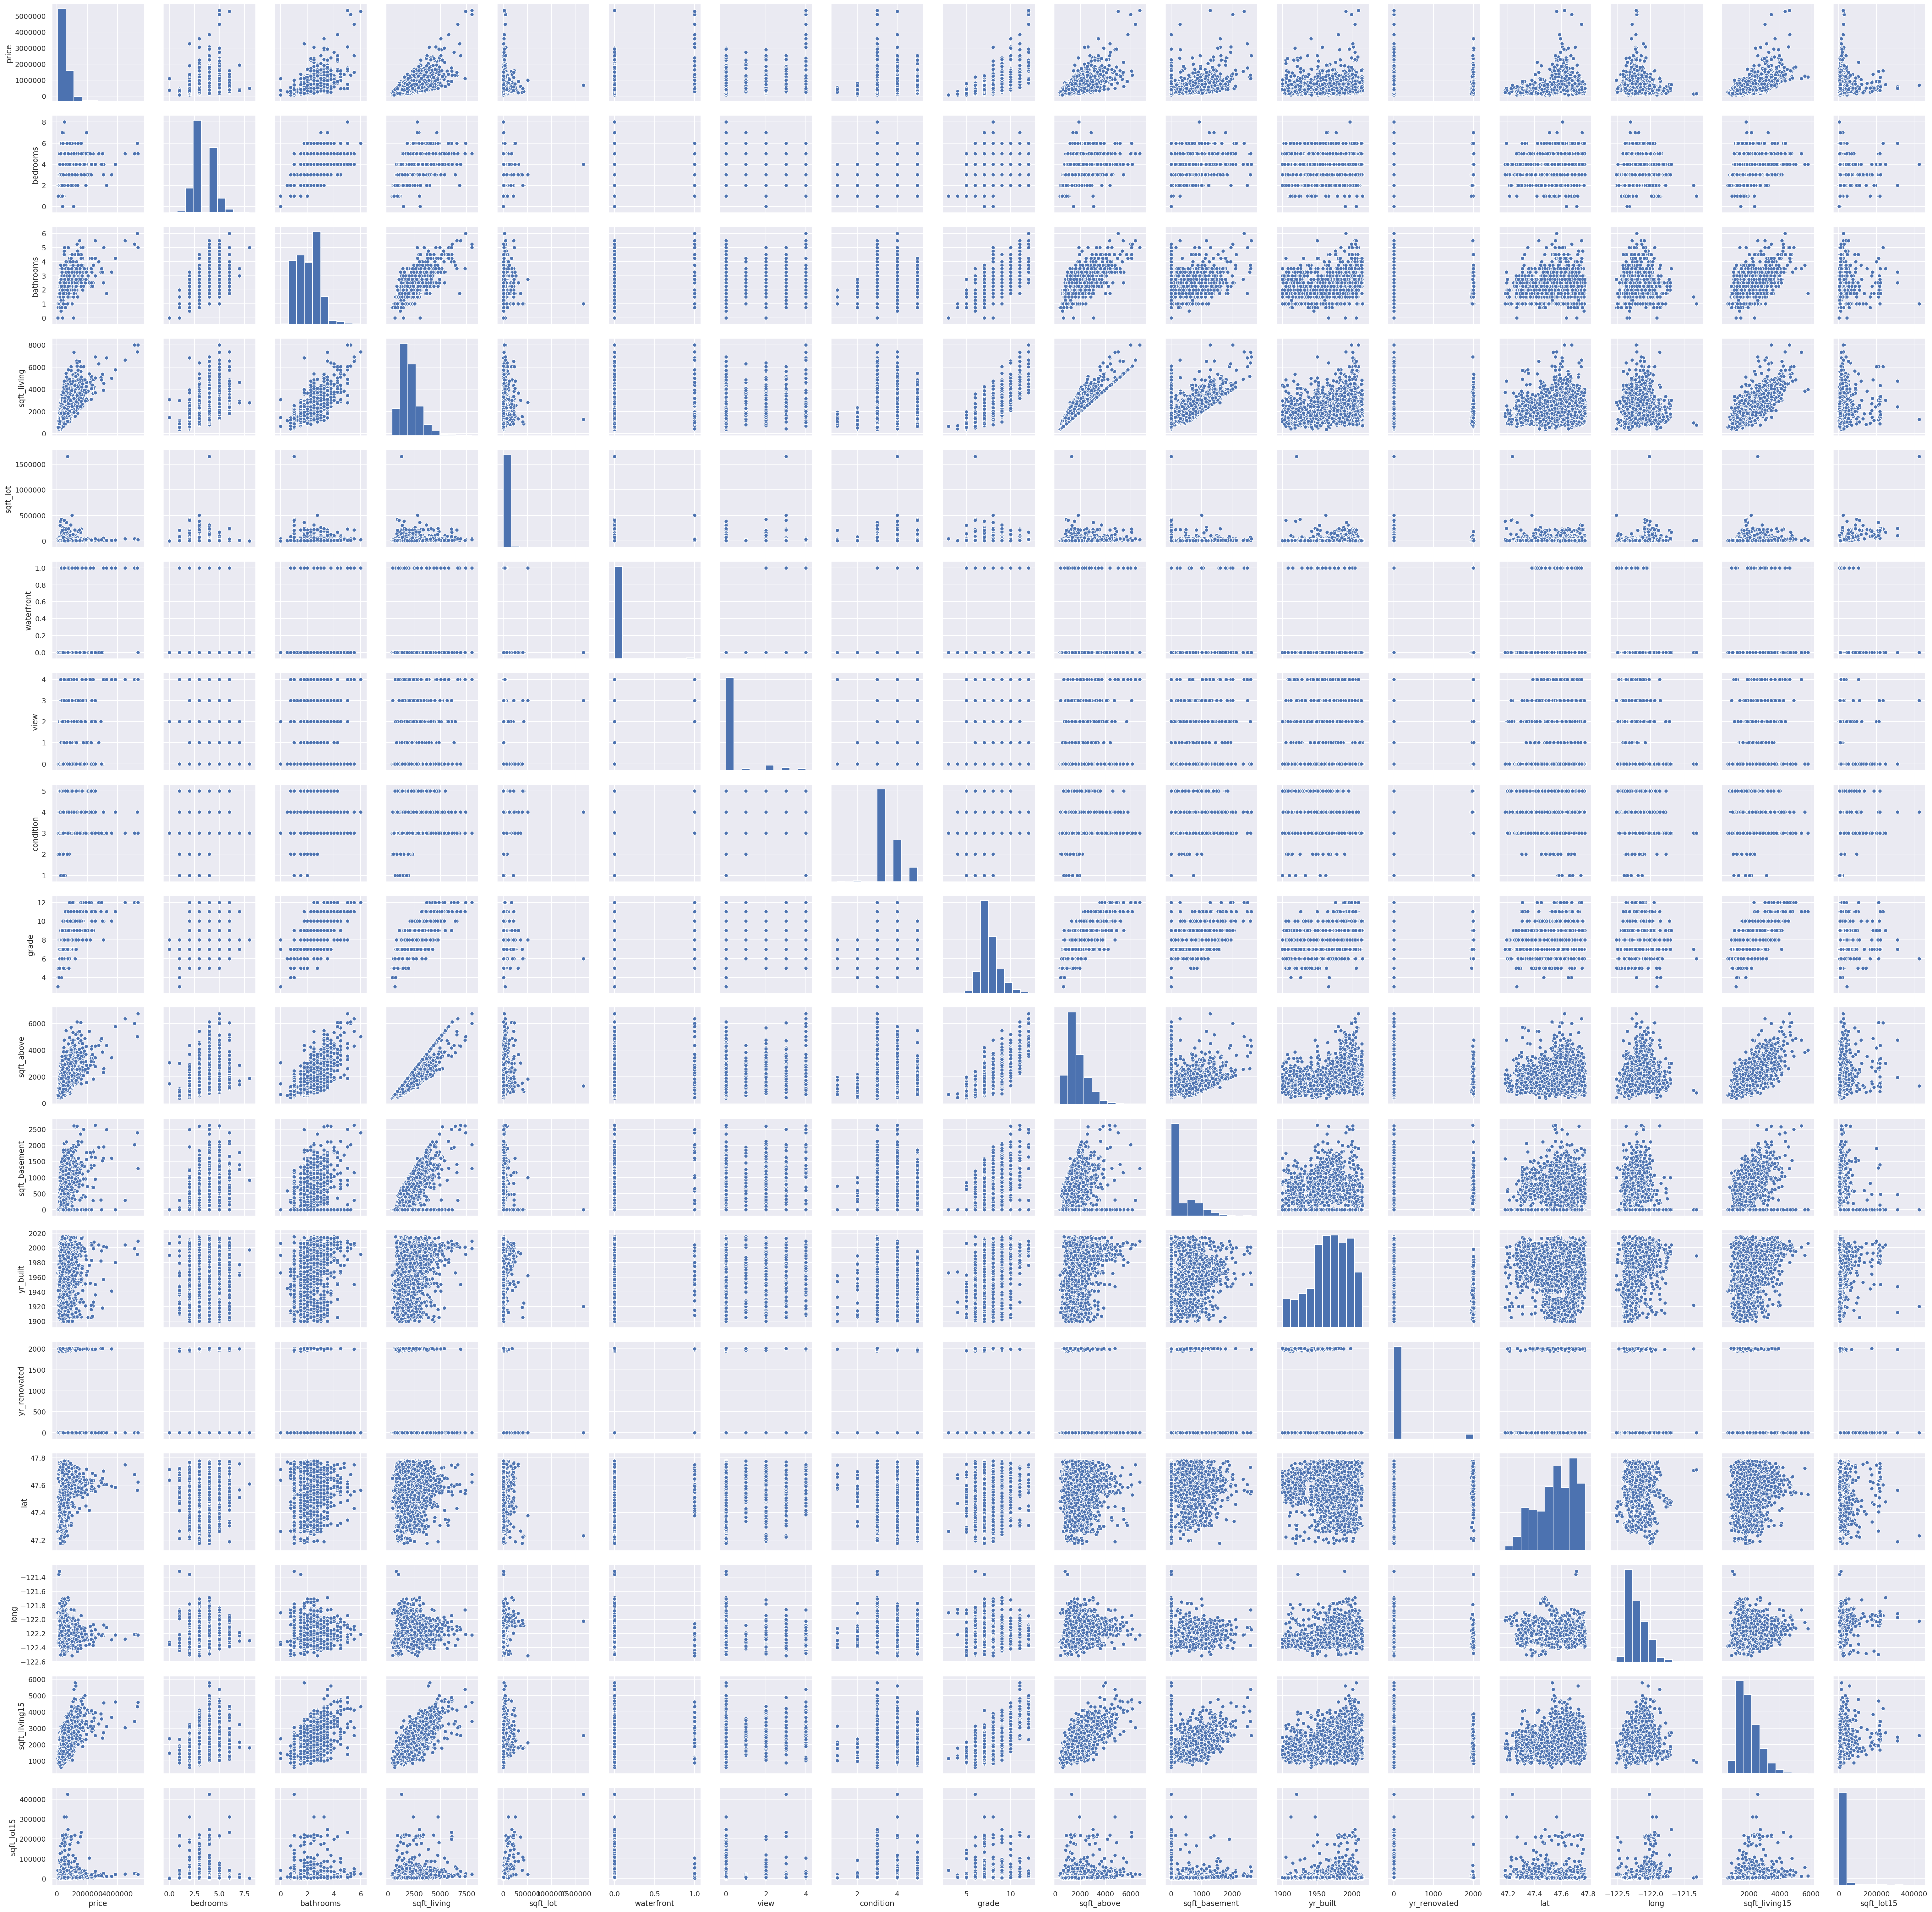

In [0]:
sns.pairplot(clean_dataset)
plt.show();

In [0]:
features = SELECTED_COLS
price_col = features.pop(6)

In [0]:
correlation={}
for f in features:
    data1 = clean_dataset[[f,price_col]]
    x1= data1[f].values
    x2= data1[price_col].values
    key = f
    correlation[key] = pearsonr(x1,x2)[0]

In [0]:
## Mengurutkan korelasi terhadap price

data_correlations = pd.DataFrame(correlation, index=['Value']).T
sorted_data_correlations = data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]
sorted_data_correlations

Value
sqft_living    0.705048
grade          0.654124
sqft_living15  0.607973
sqft_above     0.599095
bathrooms      0.525509
view           0.443541
waterfront     0.366537
sqft_basement  0.348599
lat            0.301254
bedrooms       0.292742
yr_renovated   0.122820
sqft_lot15     0.100527
sqft_lot       0.074333
condition      0.053536
yr_built       0.037051
long           0.017090

Hanya mengambil 5 features yang memiliki korelasi paling tinggi dengan price

In [0]:
SELECTED_COLS = sorted_data_correlations.T.columns[:5].tolist()
SELECTED_COLS.append(price_col)

In [0]:
SELECTED_COLS

['sqft_living', 'grade', 'sqft_living15', 'sqft_above', 'bathrooms', 'price']

In [0]:
clean_dataset = clean_dataset[SELECTED_COLS]

#### c. Standarisasi Dataset

In [0]:
scaler = preprocessing.StandardScaler()
scaled_data = scaler.fit_transform(clean_dataset)
scaled_data = pd.DataFrame(scaled_data, columns=SELECTED_COLS)
scaled_data

sqft_living     grade  sqft_living15  sqft_above  bathrooms     price
0       -0.967310 -0.527961      -0.936452   -0.712488  -1.395542 -0.823274
1        0.543385 -0.527961      -0.426358    0.501036   0.231870  0.006733
2       -1.412910 -1.385492       1.074776   -1.215059  -1.395542 -0.933294
3       -0.119582 -0.527961      -0.907303   -0.871840   1.208318  0.180034
4       -0.423894  0.329569      -0.266042   -0.099597  -0.093612 -0.066789
...           ...       ...            ...         ...        ...       ...
3159    -0.478236 -0.527961      -0.557525   -0.160887  -0.419095 -0.274225
3160    -0.250001  0.329569      -0.018283   -0.516363   0.557353 -0.132433
3161    -0.489104  0.329569       0.666701   -0.173144  -0.744577  0.642170
3162    -0.250001  0.329569      -0.149450   -0.516363  -0.744577  0.484624
3163    -0.771680 -0.527961       0.083736   -0.491848  -1.395542 -0.316237

[3164 rows x 6 columns]

### d. Membuat Cluster

Dari pair plot diatas didapat relationships dari setiap features dataset yang dipilih. Pada tahapan clustering pertama ini akan digunakan feature *price* dan akan didapasangkan dengan masing-masing features lainnya (2D).

#### d.1. Mencari Jumlah Gaussian yang Optimal 

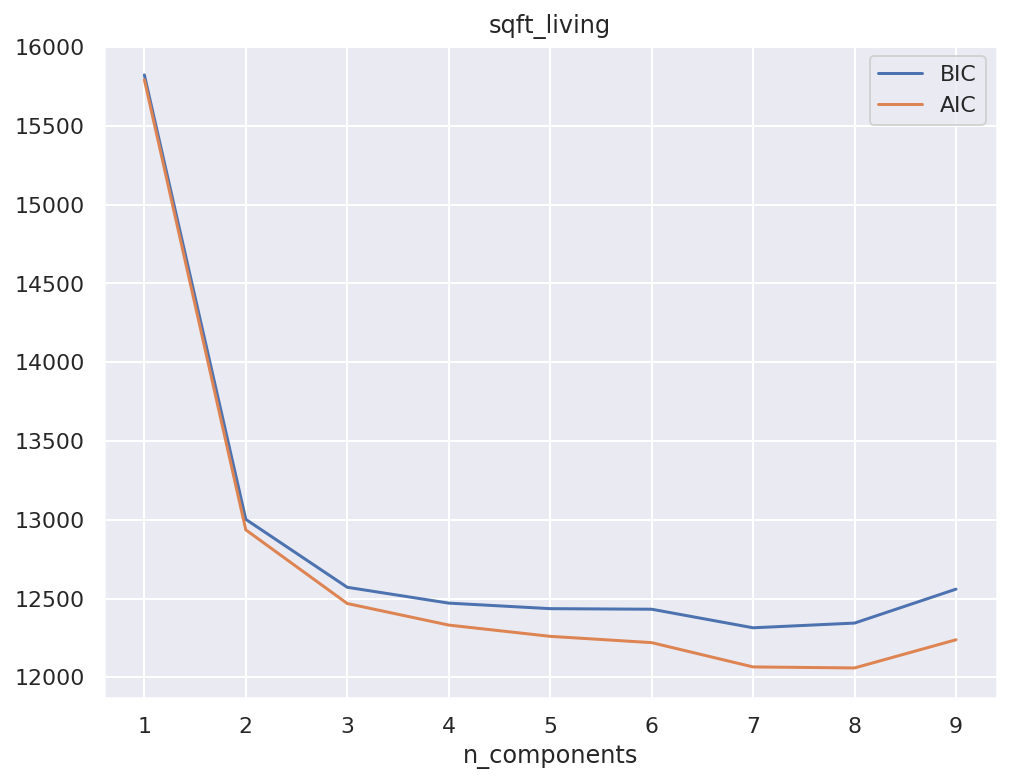

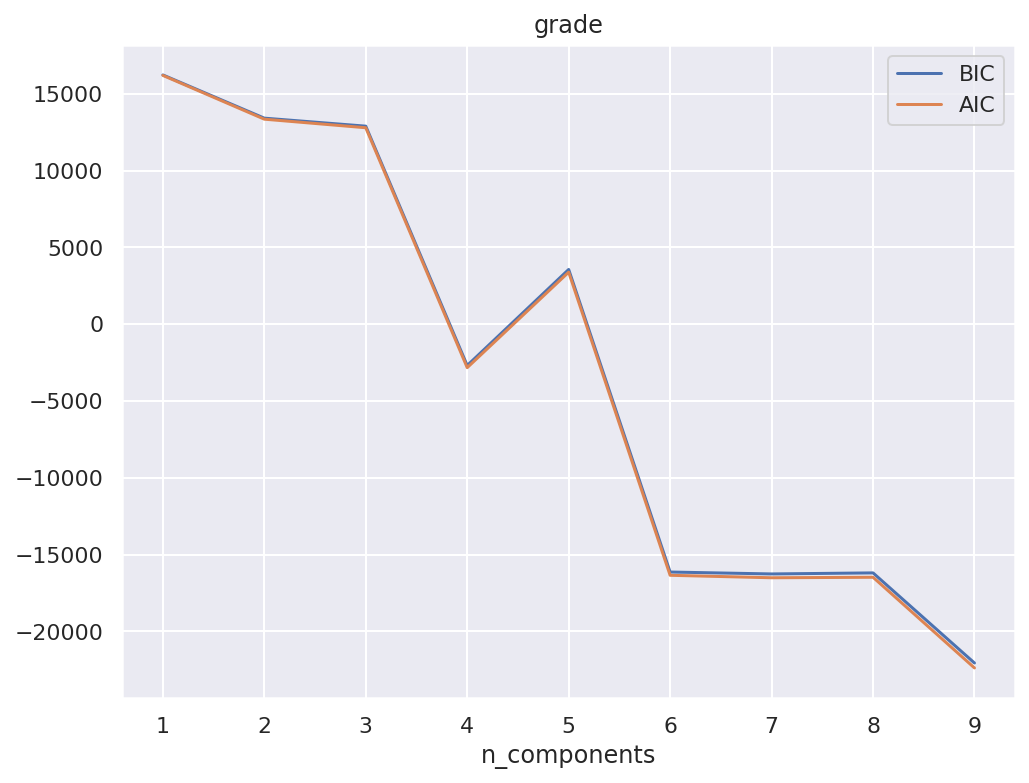

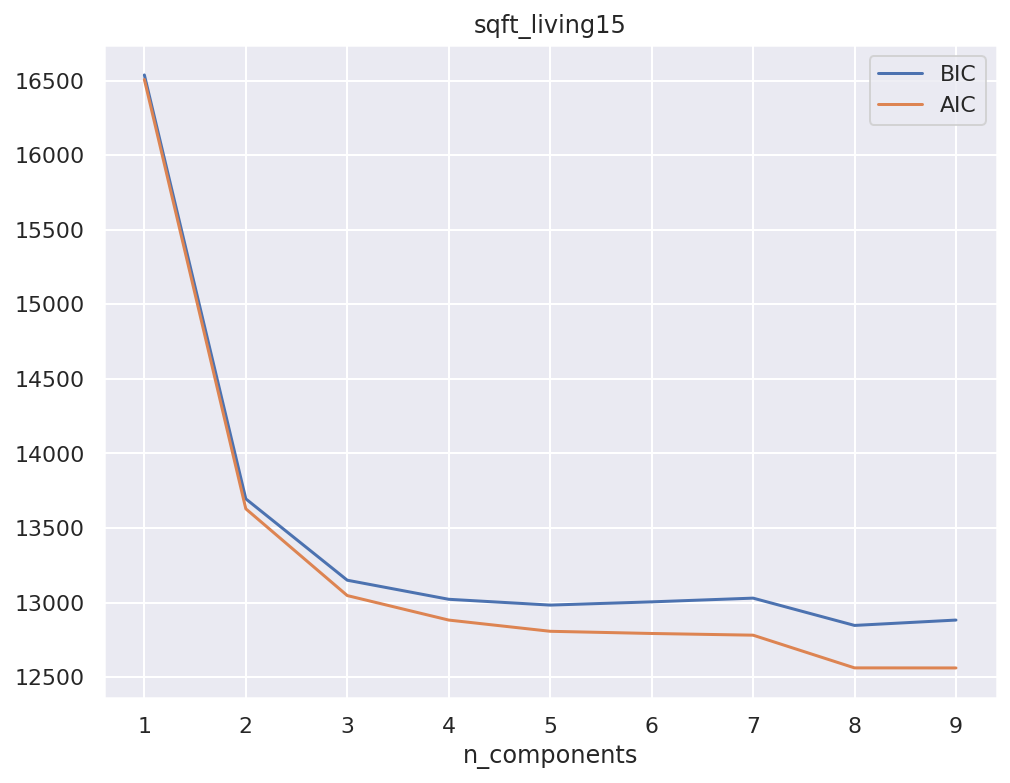

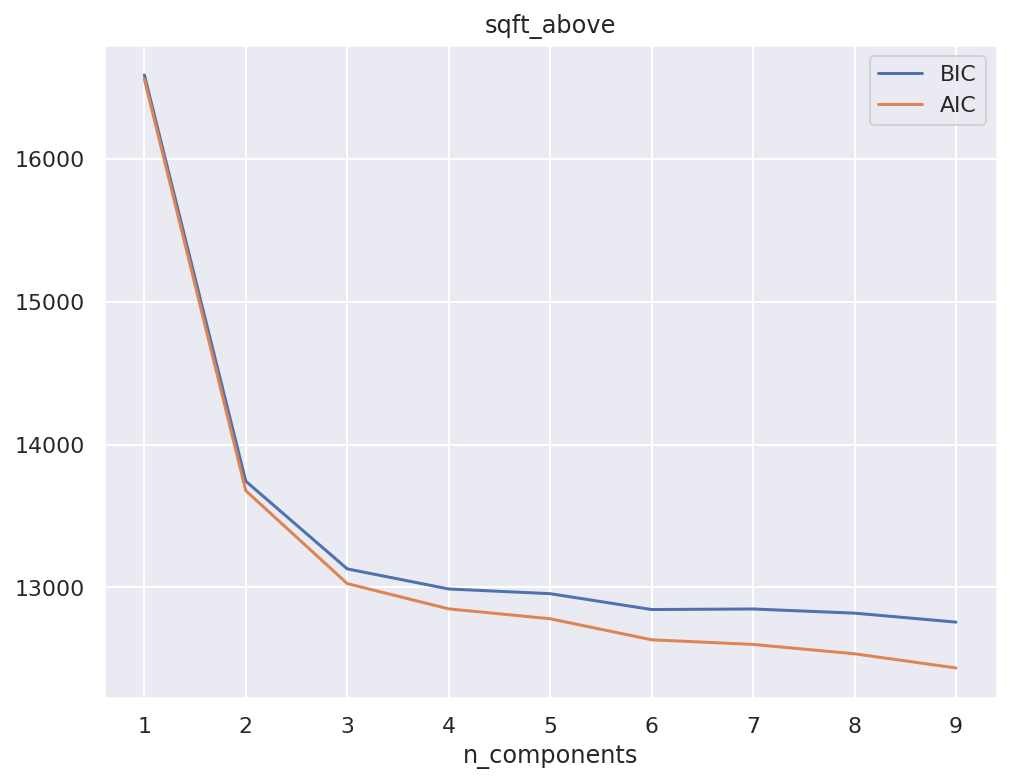

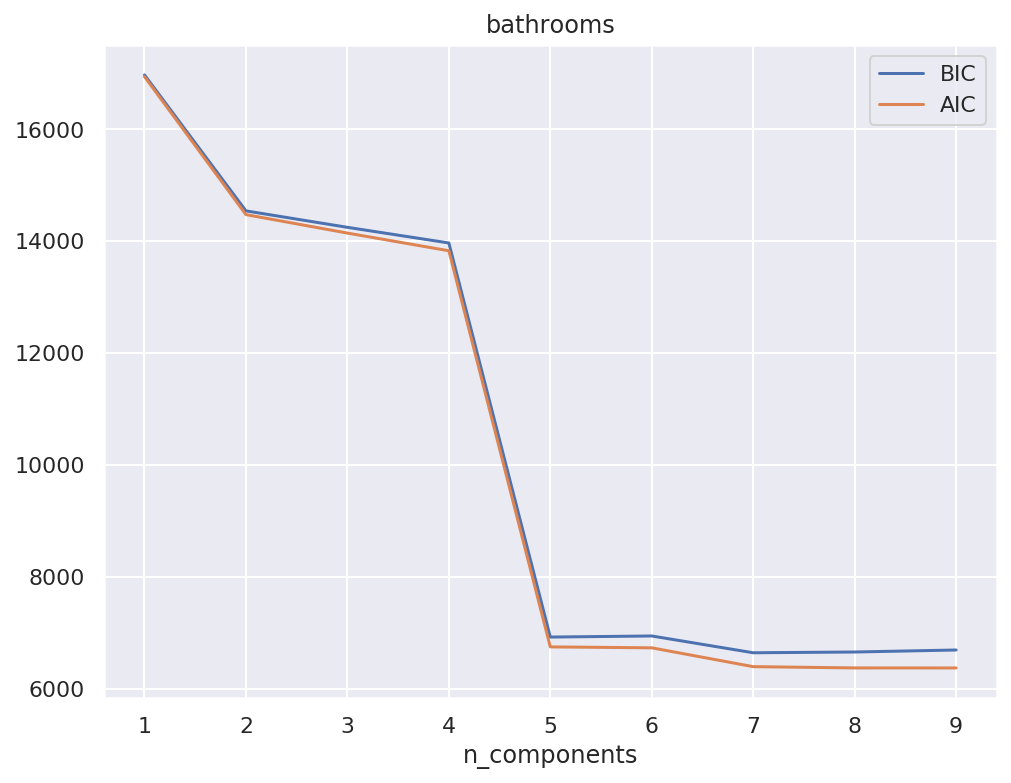

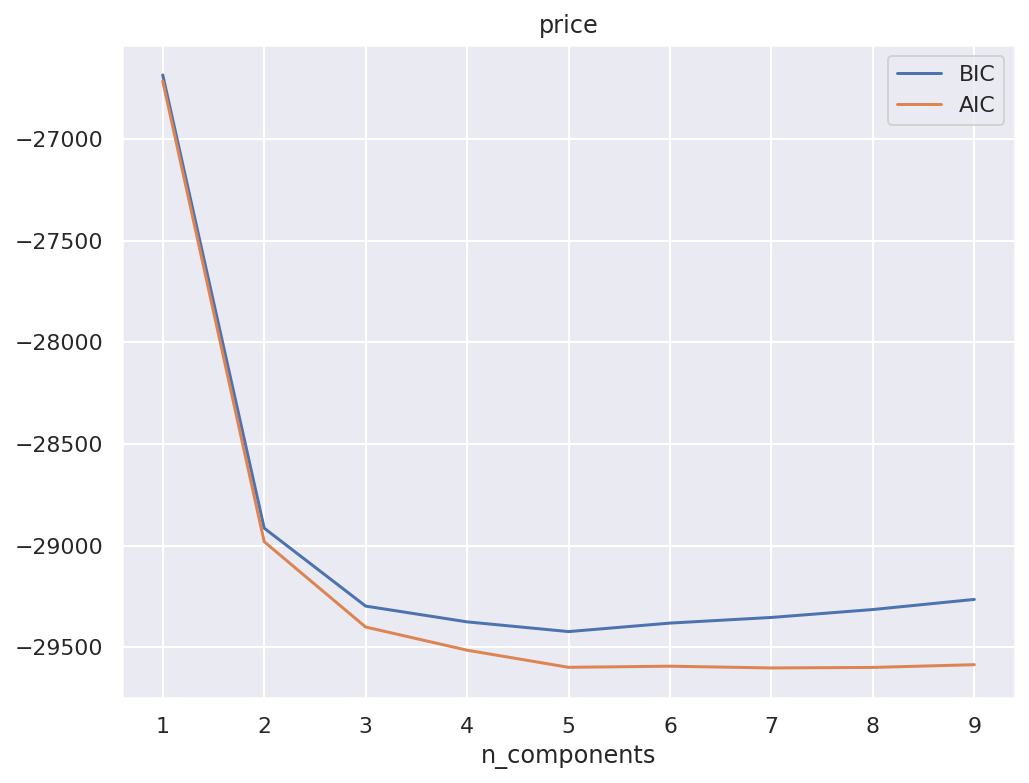

In [0]:
for f in SELECTED_COLS:
    plt.title(f)
    GMM.get_optimum_cluster(scaled_data[[price_col, f]], 10)

#### d.2 Clustering 

Proses clustering dilakukan berdasar julah gaussian yang didapat pada sub-bab d.1

#### d.2.1 Inisialisasi dengan menggunakan kmeans

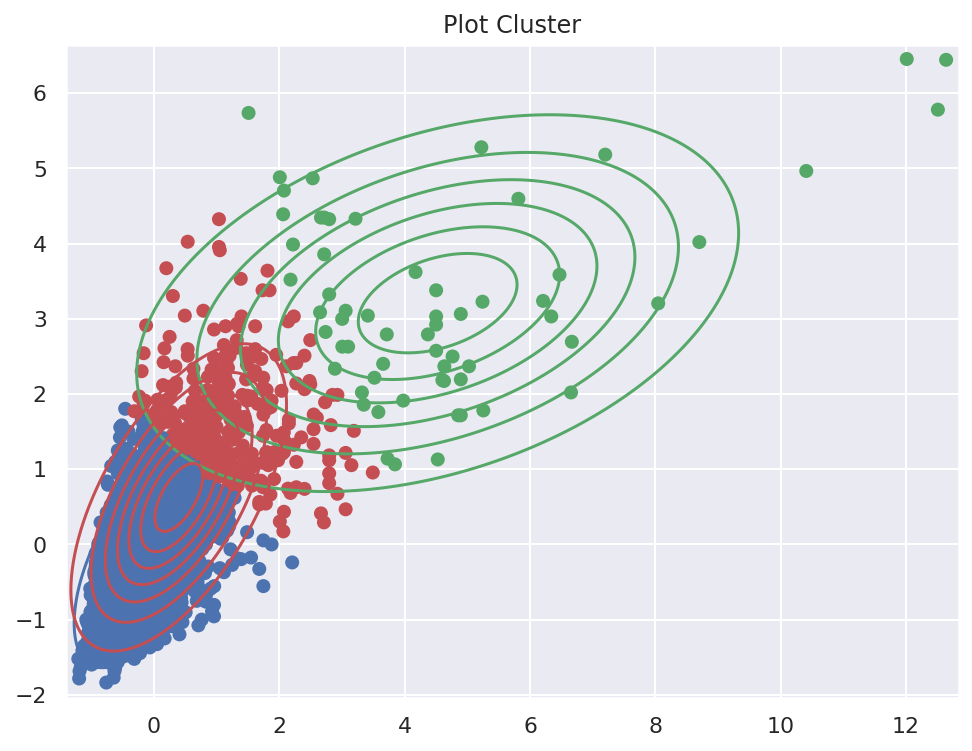

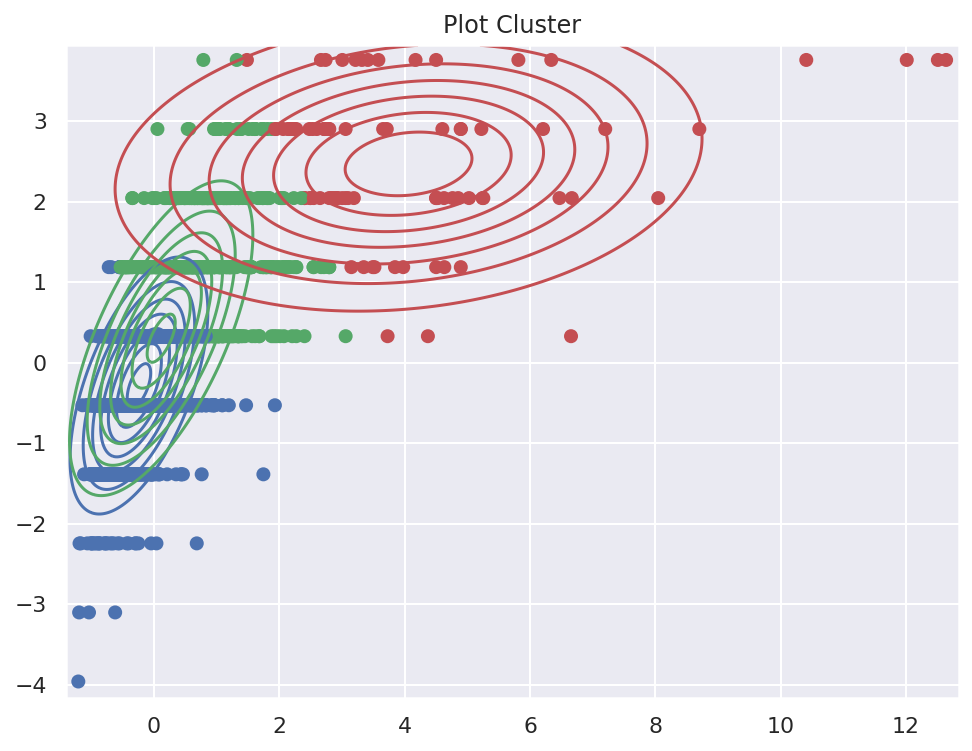

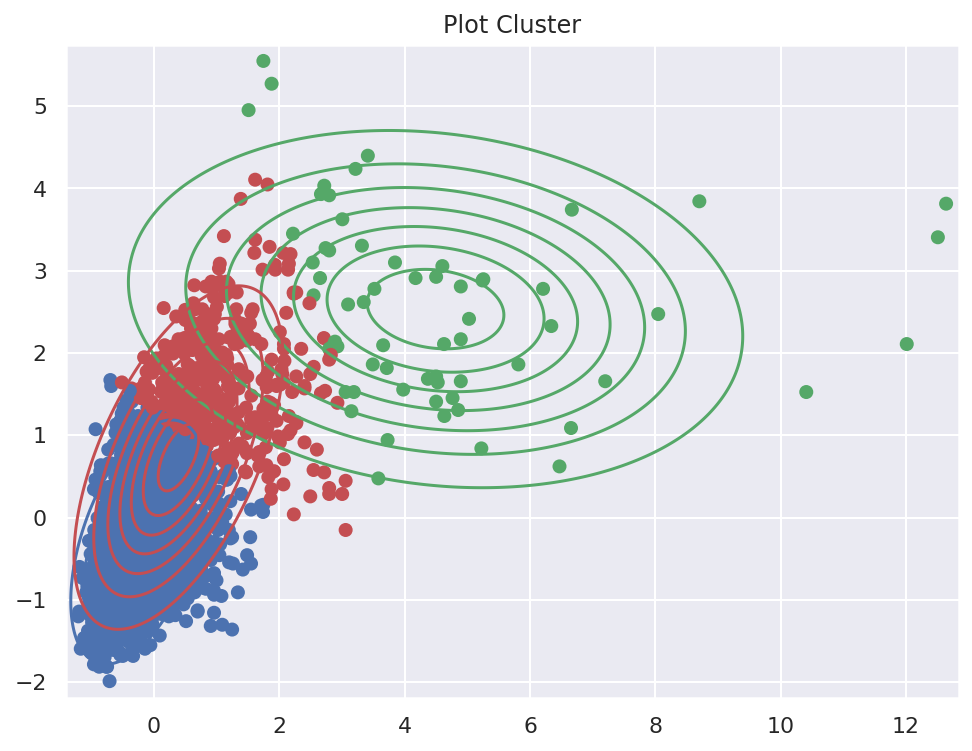

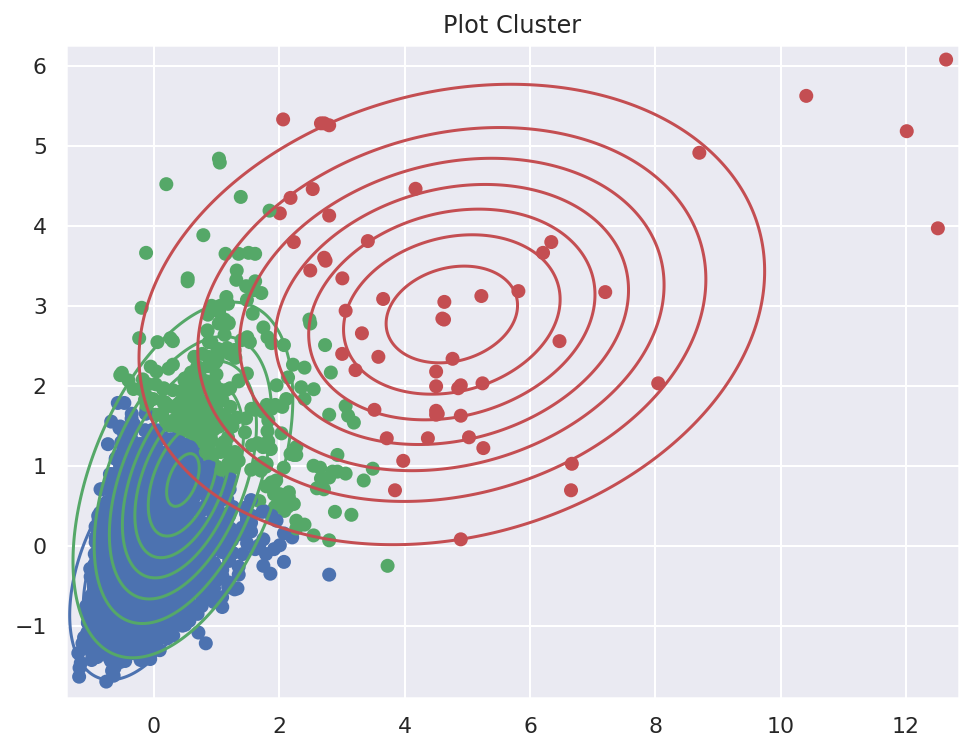

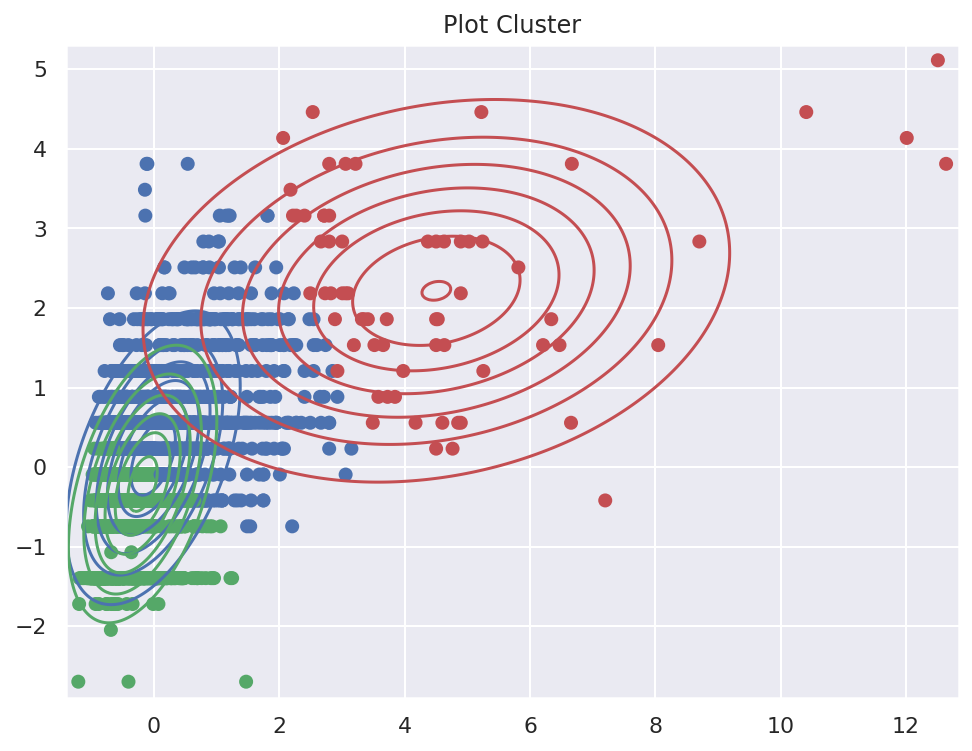

In [0]:
for f in SELECTED_COLS[:-1]:
    gmm = GMM(n_components=3, init_params='kmeans', random_state=123)
    gmm.fit(scaled_data[[price_col, f]])
    labels = gmm.predict()
    gmm.plot();

#### d.2.2 Inisialisasi secara random

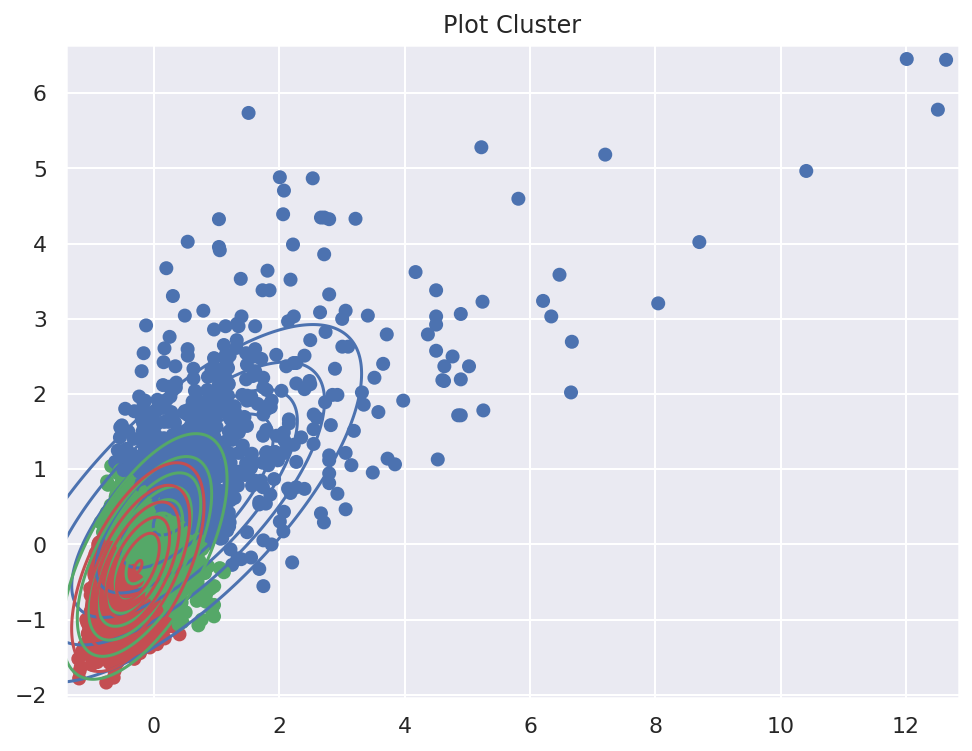

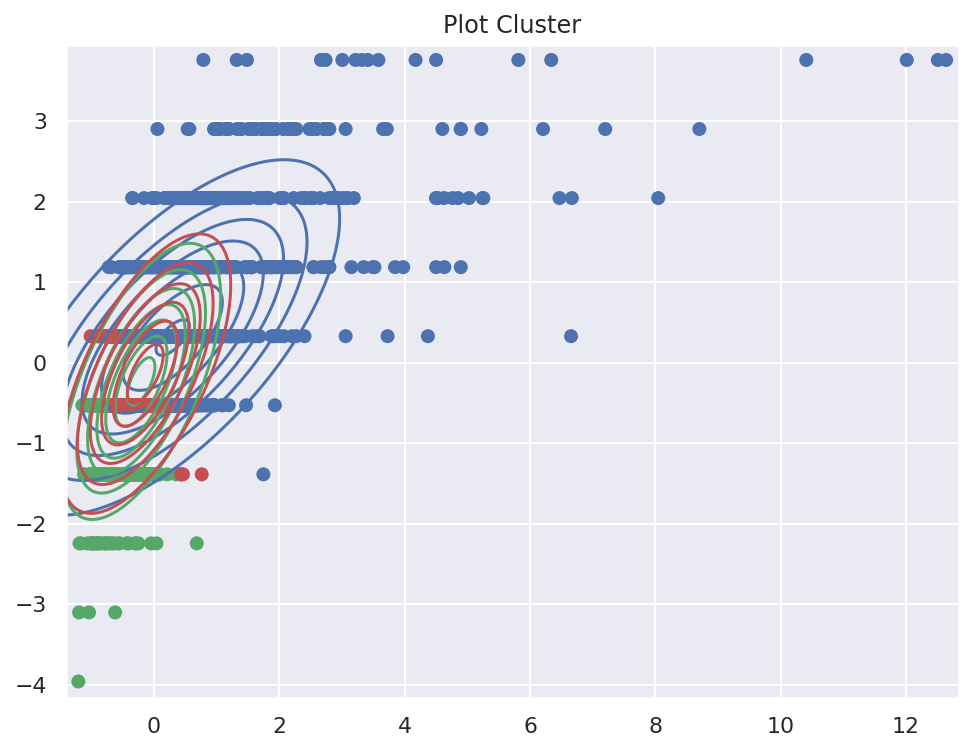

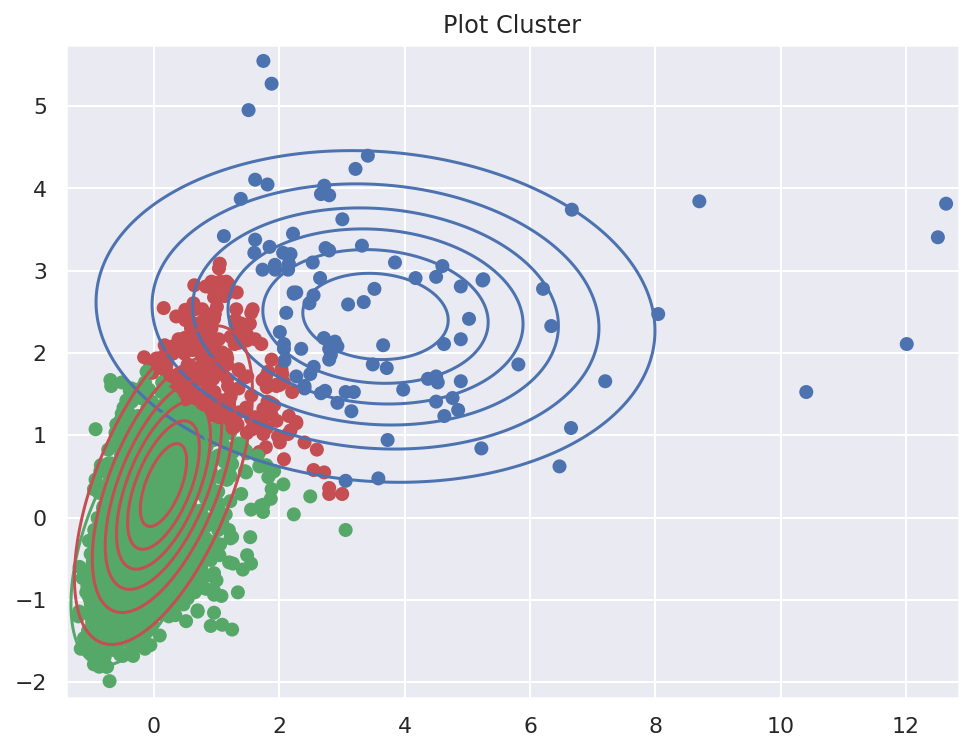

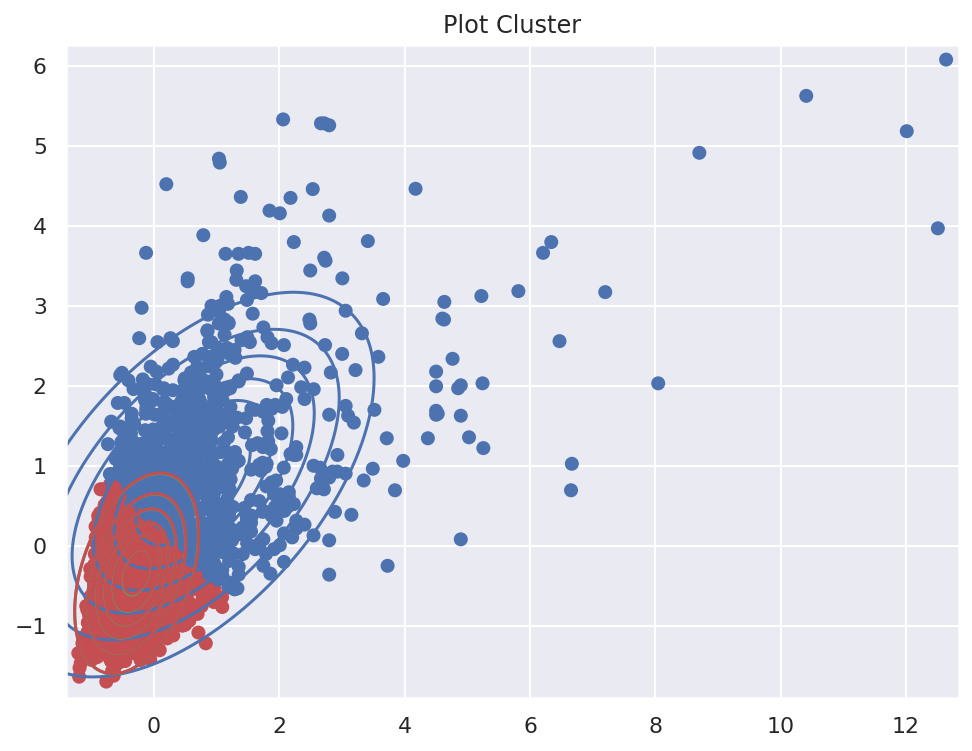

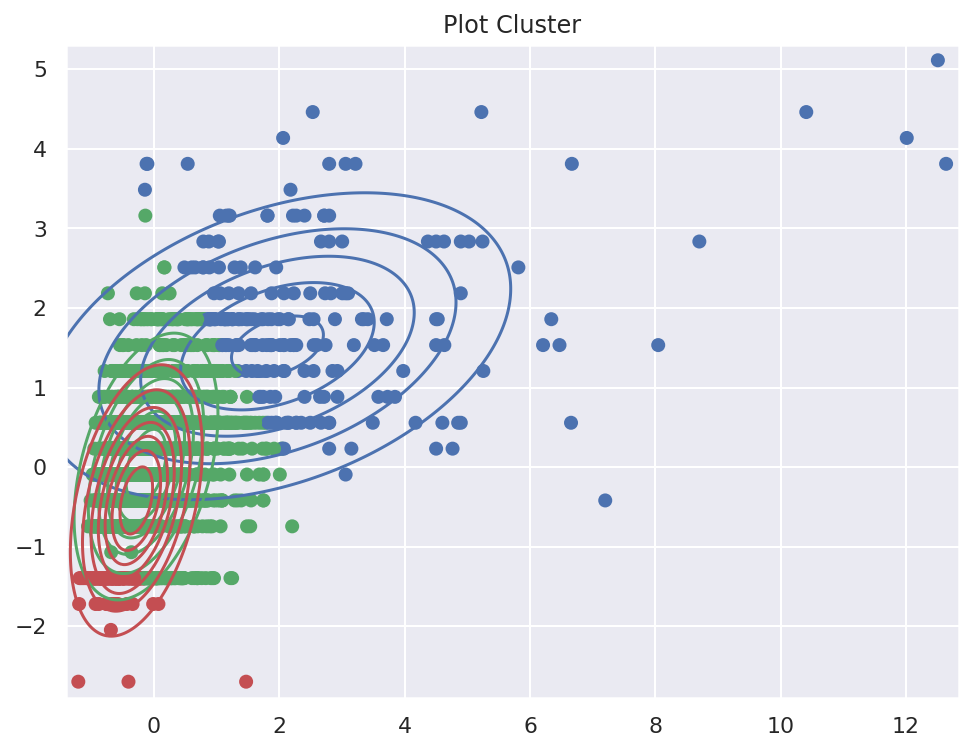

In [0]:
for f in SELECTED_COLS[:-1]:
    gmm = GMM(n_components=3, init_params='random', random_state=1111)
    gmm.fit(scaled_data[[price_col, f]])
    labels = gmm.predict()
    gmm.plot();

#### e. Clustering untuk Feature Lebih dari 2

In [0]:
gmm = GMM(n_components=3, init_params='random', random_state=1111)
gmm.fit(scaled_data)
labels = gmm.predict()

In [0]:
scaled_data['labels'] = labels
scaled_data

sqft_living     grade  sqft_living15  ...  bathrooms     price  labels
0       -0.967310 -0.527961      -0.936452  ...  -1.395542 -0.823274       2
1        0.543385 -0.527961      -0.426358  ...   0.231870  0.006733       1
2       -1.412910 -1.385492       1.074776  ...  -1.395542 -0.933294       2
3       -0.119582 -0.527961      -0.907303  ...   1.208318  0.180034       1
4       -0.423894  0.329569      -0.266042  ...  -0.093612 -0.066789       1
...           ...       ...            ...  ...        ...       ...     ...
3159    -0.478236 -0.527961      -0.557525  ...  -0.419095 -0.274225       1
3160    -0.250001  0.329569      -0.018283  ...   0.557353 -0.132433       1
3161    -0.489104  0.329569       0.666701  ...  -0.744577  0.642170       1
3162    -0.250001  0.329569      -0.149450  ...  -0.744577  0.484624       1
3163    -0.771680 -0.527961       0.083736  ...  -1.395542 -0.316237       2

[3164 rows x 7 columns]

In [0]:
np.unique(labels)

array([0, 1, 2])